In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.models import load_model

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

## Check GPU availability

In [ ]:
# Get information about the GPU
gpu_info = !nvidia-smi
# Join the GPU information into a single string
gpu_info = '\n'.join(gpu_info)

# Check of the string failes is present in the GPU information
if gpu_info.find('failed') >= 0:
  # Print a message to indicate that the systme is not connected to GPU
  print('Not connected to a GPU')

# Or print the GPU information
else:
  print(gpu_info)

Tue Dec  5 09:07:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get information about the memory

In [ ]:
# Import library
from psutil import virtual_memory

# Get total available RAM in gigabytes
ram_gb = virtual_memory().total / 1e9
# Print the current RAM available
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

#Check if you are using high RAM (over 20 gigabytes)
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Download the datasets from drive
- data_dir


In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the paths to your data folders
# Store the main data directory which is a folder containing the four sub folders
data_dir = 'folder_with_4_folders_with_all_data'

# Extract the pathway directory to each of the subfolder. Tailor.
train_image_dir = os.path.join(data_dir, 'train_image')
train_mask_dir = os.path.join(data_dir, 'train_mask')
validation_image_dir = os.path.join(data_dir, 'validation_image')
validation_mask_dir = os.path.join(data_dir, 'validation_mask')

# Get a list of image and mask file paths
# Extract the pathways to each of the images
train_image_paths = glob.glob(os.path.join(train_image_dir, '*.png'))
train_mask_paths = glob.glob(os.path.join(train_mask_dir, '*.png'))
validation_image_paths = glob.glob(os.path.join(validation_image_dir, '*.png'))
validation_mask_paths = glob.glob(os.path.join(validation_mask_dir, '*.png'))

# Sort the paths for each folder to make sure training and validation sets correspond
train_image_paths = sorted(train_image_paths)
train_mask_paths = sorted(train_mask_paths)
validation_image_paths= sorted(validation_image_paths)
validation_mask_paths =sorted(validation_mask_paths)

# Checkpoints
print("train image", len(train_image_paths))
print("train mask", len(train_mask_paths))
print("validation image", len(validation_image_paths))
print("validation maks", len(validation_mask_paths))

train image 306
train mask 306
validation image 34
validation maks 34


Define a function that will return a directory that contains the corresponding image file name, image and true mask.
TensorFlow library is used to read and decode the files.

In [ ]:
# Define the function to load image and corresponding maks with tenseflow
def load_image_and_mask(image_path, mask_path):
    # Read the image path as binary data
    image = tf.io.read_file(image_path)
		# Decode the binary image data and specify 3 channels for coloured RGB image
    image = tf.io.decode_png(image,channels=3)
		# Read the corresponding mask path as binary data
    mask = tf.io.read_file(mask_path)
    # Decode the binary mask data and specify 1 channel for segmentation image
    mask = tf.io.decode_png(mask,channels=1)

		# Return a dictionary containing the image file name, image data, and segmentation mask data.
    return {'file_name': image_path, 'image': image, 'segmentation_mask': mask}

Define the values for the hyperparameters

In [ ]:
# Define the image size
img_size = 1024

# Define batch size
BATCH_SIZE = 1

# Define buffer size
BUFFER_SIZE = 1000

# For ADAM optimizer
learning_rate=0.0001  # Custom learning rate
beta_1=0.9           # Custom beta_1
beta_2=0.999         # Custom beta_2
epsilon=1e-7         # Custom epsilon

# Define the number epochs
NUM_EPOCHS = 20

# Define the number of validation subslits
VAL_SUBSPLITS = 5

### Preprocess the data

Define the function to resize, augment and normalize the data

In [ ]:
# Define RESIZE function
def resize(input_image, input_mask): # Takes image and corresponding mask as inputs
    # Resize the image with tf.resize
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    # Resize the mask with tf.resize
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image, input_mask

# Define AUGMENT function
def augment(input_image, input_mask):# Takes image and corresponding mask as inputs
   # Generate a random value to determine whether augmentation should be applied or not
   # 50% chance of augmentation being performed
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   if tf.random.uniform(()) > 0.5:
       # Adjust the brightness on image
       input_image = tf.image.random_brightness(input_image, max_delta=0.2)

   if tf.random.uniform(()) > 0.5:
       # Adjust the contrast on image
       input_image = tf.image.random_contrast(input_image, lower=0.5, upper=1.5)

   if tf.random.uniform(()) > 0.5:
       # Adjust the hue on image
       input_image = tf.image.random_hue(input_image, max_delta=0.2)

   if tf.random.uniform(()) > 0.5:
       # Adjust the saturation on image
       input_image = tf.image.random_saturation(input_image, lower=0.5, upper=1.5)

   return input_image, input_mask

# Define NORMALIZE function
def normalize(input_image, input_mask): # Takes image and corresponding mask as inputs
   # Normalize input image to values 0-1
   input_image = tf.cast(input_image, tf.float32) / 255.0
   # Normalize input mask to values 0-1
   input_mask = tf.cast(input_mask, tf.float32) / 255
   return input_image, input_mask

Pre-process the training dataset: resize, augment and normalize.

In [ ]:
# TRAIN DATASET

# Load data
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(lambda image_path, mask_path: load_image_and_mask(image_path, mask_path))

# Resize
train_dataset = train_dataset.map(lambda x: resize(x["image"], x["segmentation_mask"]))

# Augment
train_dataset = train_dataset.map(lambda x, y: augment(x, y))

# Normalize
train_dataset = train_dataset.map(lambda x, y: normalize(x, y))

Pre-process validation dataset: resize and normalize. No augmentation

In [ ]:
# VALIDATION DATASET

# Load data
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_image_paths, validation_mask_paths))
validation_dataset = validation_dataset.map(lambda image_path, mask_path: load_image_and_mask(image_path, mask_path))

# Resize
validation_dataset = validation_dataset.map(lambda x: resize(x["image"], x["segmentation_mask"]))

# Normalize
validation_dataset = validation_dataset.map(lambda x, y: normalize(x, y))

In [ ]:
# Prepare the training and validation batches

# Training batched
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Validation batches
validation_batches = validation_dataset.batch(1)


Checkpoint: Check that the dataset has been uploaded correclty by printing images with corrsponding mask

In [ ]:
# Define a function to display image and corresponding mask
def display(display_list):
 # Determine the figure size
 plt.figure(figsize=(15, 15))
 # Define the titles for each subplot
 title = ["Input Image", "True Mask"]

 # Loop through list with with image and mask
 for i in range(len(display_list)):
  # Create subplot for each image
   plt.subplot(1, len(display_list), i+1)
   # Title the plot
   plt.title(title[i])
   # Display the image
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap="gray")
   # Turn off axis label
   plt.axis("off")
# Show the figures
 plt.show()


# Get a sample batch from the training batches
sample_batch = next(iter(train_batches))

# Randomly choose an index from the batch
random_index = np.random.choice(sample_batch[0].shape[0])

# Extract the sample image and mask using the random index
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

# Call function and simplay the image and mask
display([sample_image, sample_mask])

NameError: ignored

### Define U-net architecture

In [ ]:
#define a funtion for the conv 3x3 operation (purple)
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters,
                     3,
                     padding = "same",
                     activation = "relu",
                     kernel_initializer = "he_normal")(x)
   # The second operation: Conv2D then ReLU activation
   x = layers.Conv2D(n_filters,
                     3,
                     padding = "same",
                     activation = "relu",
                     kernel_initializer = "he_normal")(x)
   return x

#define function for downsample max pool 2x2 operations (red)
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

#define function for upsample up-conv 2x2 operations (green)
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters,
                              3,
                              2,
                              padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

Build functional API keras model for 2 class classification

In [ ]:
# Define function to build unet model
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(None,None,3)) #hyperparameter, has to be the same as size of image

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    #outputs = layers.Conv2D(2, 1, padding="same", activation = "softmax")(u9)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)


    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
# Store the function in variable to define the model name
unet_model = build_unet_model()

NameError: ignored

# Compile
*   Define adam optimizer
*   Define dice loss function
*   Define dice loss metrics



In [ ]:
# Define a function that creates a custom Adam optimizer
def custom_optimizer():
    return tf.keras.optimizers.Adam(
        learning_rate,  # Custom learning rate
        beta_1,           # Custom beta_1
        beta_2,         # Custom beta_2
        epsilon,         # Custom epsilon
    )


# Define loss function and store in keras class
@keras.saving.register_keras_serializable()
# Inherit class from tf.keras.losses.Loss
class DiceLoss(tf.keras.losses.Loss):
    # Initialise the loss function parameters
    def __init__(self, smooth=1, gama=2):
        super(DiceLoss, self).__init__()
        # Name loss function
        self.name = 'NDL'
        # Apply smoothing factor to avois division by zero
        self.smooth = smooth
        # Exponent valye for gama in denominator
        self.gama = gama

    # Call methds to compute the loss
    def call(self, y_true, y_pred):
        # Convert to float32
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        # Numerator of the dice loss formula
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        # Denominator of the dice loss formulae
        denominator = tf.reduce_sum(y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        # Compute the final dice loss result
        result = 1 - tf.divide(nominator, denominator)
        return result

# Define dice coefficient metrics
def dice_coefficient_metric(y_true, y_pred, smooth=1):
    # Compute intersection between true and prediction values
    intersection = tf.reduce_sum(y_true * y_pred)
    # Compute denominator
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    # Compute dice coefficient
    dice_coefficient = (2.0 * intersection + smooth) / denominator
    return dice_coefficient

In [ ]:
# Compile the model
unet_model.compile(
    optimizer=custom_optimizer(),# Use custom optimizer (here Adam)
    loss= DiceLoss(),  # Use custom loss function
    metrics=[dice_coefficient_metric])  # Use dice coefficient as a metric

# Train the model

In [ ]:
# Get the total number of training image paths
TRAIN_LENGTH = len(train_image_paths)
# Calculate the number of steps per epoch for training
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
# Get the total number of validation image paths
VAL_LENGTH = len(validation_image_paths)
# Calculate the number of steps per epoch for validation
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE

In [ ]:
# Train the model
model_train = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/20
306/306 [==============================] - 390s 1s/step - loss: 0.1429 - dice_coefficient_metric: 0.7848 - val_loss: 0.1260 - val_dice_coefficient_metric: 0.8089
Epoch 2/20
306/306 [==============================] - 356s 1s/step - loss: 0.1403 - dice_coefficient_metric: 0.7842 - val_loss: 0.1259 - val_dice_coefficient_metric: 0.8078
Epoch 3/20
306/306 [==============================] - 355s 1s/step - loss: 0.1394 - dice_coefficient_metric: 0.7821 - val_loss: 0.1230 - val_dice_coefficient_metric: 0.8152
Epoch 4/20
306/306 [==============================] - 355s 1s/step - loss: 0.1391 - dice_coefficient_metric: 0.7852 - val_loss: 0.1264 - val_dice_coefficient_metric: 0.8081
Epoch 5/20
306/306 [==============================] - 355s 1s/step - loss: 0.1387 - dice_coefficient_metric: 0.7818 - val_loss: 0.1244 - val_dice_coefficient_metric: 0.8110
Epoch 6/20
306/306 [==============================] - 355s 1s/step - loss: 0.1384 - dice_coefficient_metric: 0.7830 - val_loss: 0.1225 

In [ ]:
# Save the trained model as Keras native format

#Define the variable for the last part of the website
model_version = " "

# Construct the model path using the variable
model_path = f"path_to_save_model/{model_version}.model.keras"

# Save the model
unet_model.save(model_path)

## Loss function and dice score plot of currently run model

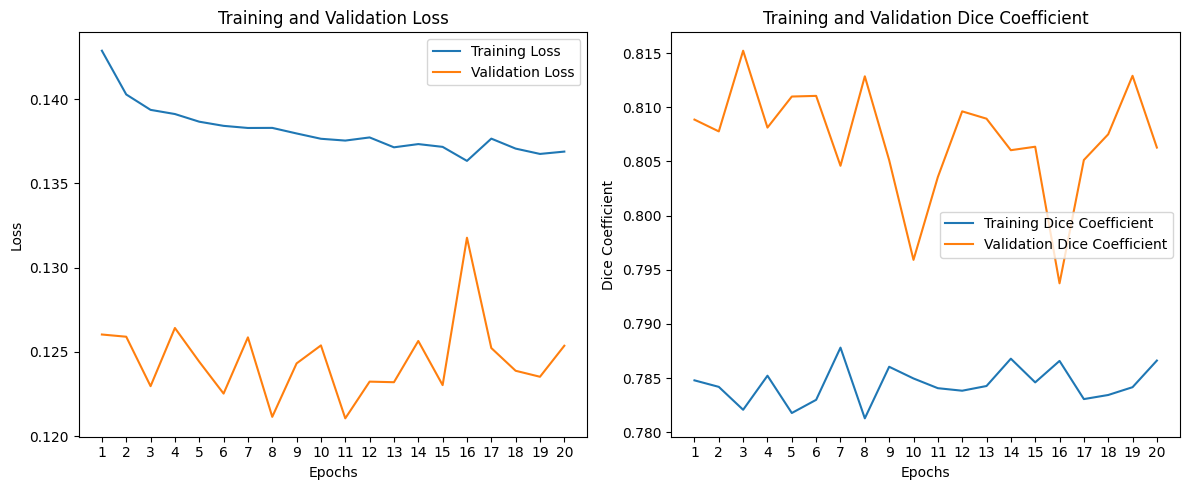

In [ ]:
# Extract the training and validation loss and dice coefficient values from the model training history
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
dice_coef = model_train.history['dice_coefficient_metric']
val_dice_coef = model_train.history['val_dice_coefficient_metric']

# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, len(loss) + 1)

# Create subplots to display both loss and the Dice coefficient
plt.figure(figsize=(12, 5))

# Plot and label the training and validation loss values
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1, len(loss) + 1, step=1))
plt.legend(loc='best')


# Plot and label the training and validation Dice coefficients
plt.subplot(1, 2, 2)
plt.plot(epochs, dice_coef, label='Training Dice Coefficient')
plt.plot(epochs, val_dice_coef, label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.xticks(np.arange(1, len(loss) + 1, step=1))
plt.legend(loc='best')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
# Evaluate the model on the validation dataset, including the custom metric
evaluation = unet_model.evaluate(validation_batches)

# The `evaluation` variable contains the custom metric value
print("Dice Coefficient:", evaluation)

34/34 [==============================] - 11s 319ms/step - loss: 0.1254 - dice_coefficient_metric: 0.8063
Dice Coefficient: [0.12536850571632385, 0.8062760233879089]


### Evaluate a saved model
- upload the model
- compile the model
- print the mean dice score

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
loaded_model = tf.keras.models.load_model("pathway_to_saved_model.model.keras",
                                       custom_objects={'DiceLoss': DiceLoss},
                                       compile = False)

In [ ]:
# Compile the model
loaded_model.compile(
    optimizer=custom_optimizer(),
    loss= DiceLoss(),  # Use your custom loss function
    metrics=[dice_coefficient_metric])  # Add dice coefficient as a metric)

In [ ]:
# Evaluate the model on the validation dataset, including the custom metric
evaluation = loaded_model.evaluate(validation_batches)


# The `evaluation` variable contains the custom metric value
print("Dice Coefficient:", evaluation)

34/34 [==============================] - 2s 28ms/step - loss: 0.1159 - dice_coefficient_metric: 0.8013
Dice Coefficient: [0.11586921662092209, 0.8013176918029785]


### Prediction

**Code to see the predictions of recently trained model or loaded model (see comments in code).**

1/1 [==============================] - 0s 370ms/step


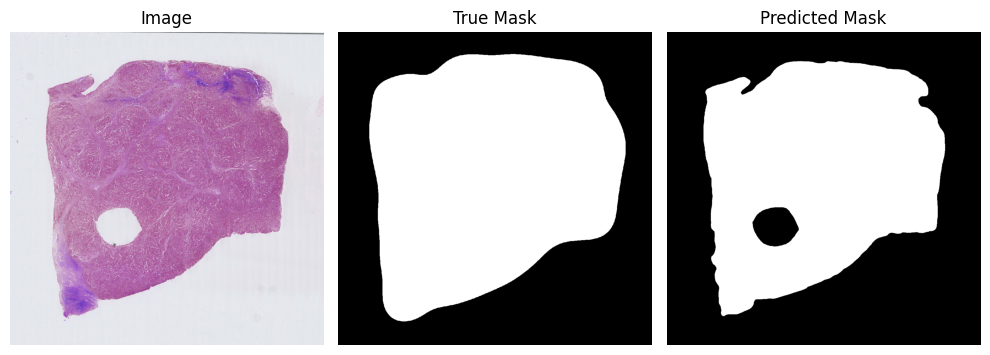

1/1 [==============================] - 0s 27ms/step


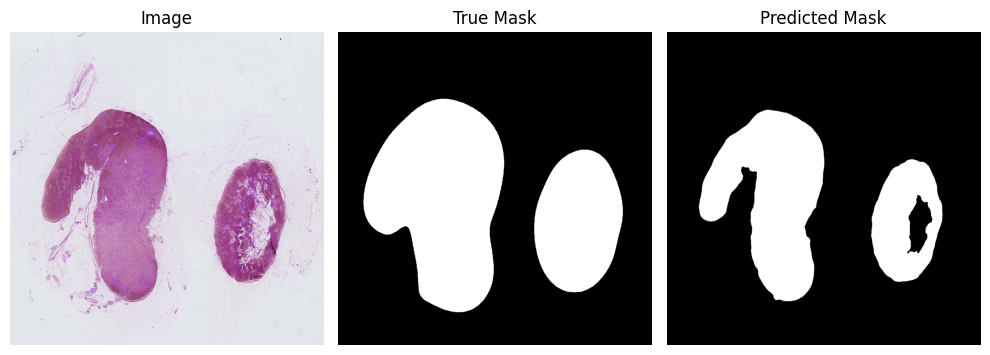

1/1 [==============================] - 0s 29ms/step


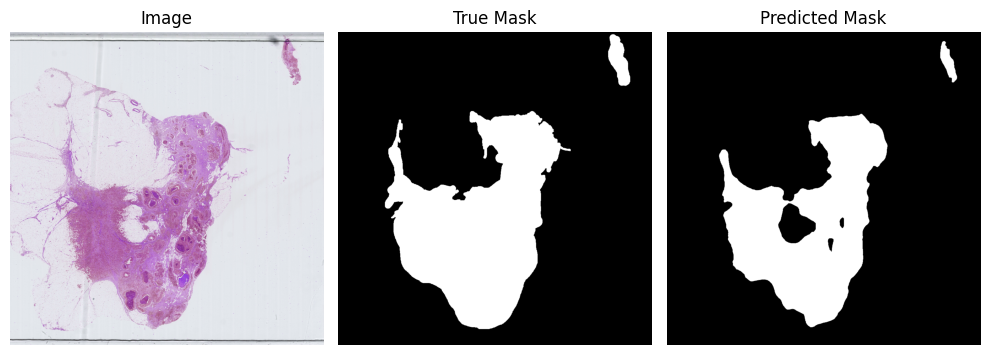

1/1 [==============================] - 0s 28ms/step


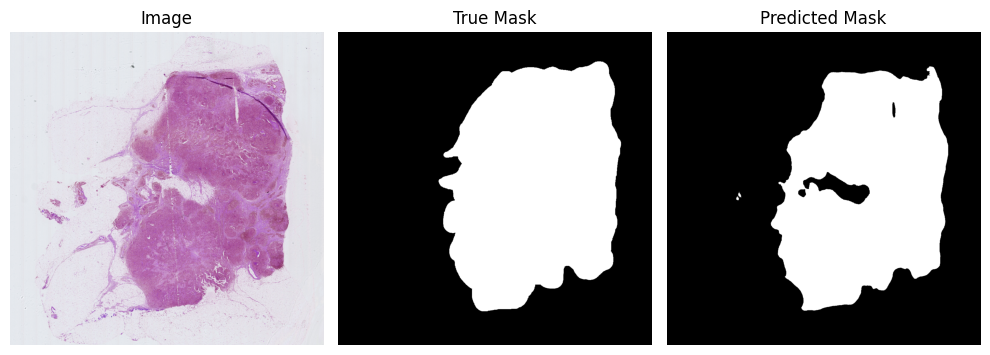

1/1 [==============================] - 0s 27ms/step


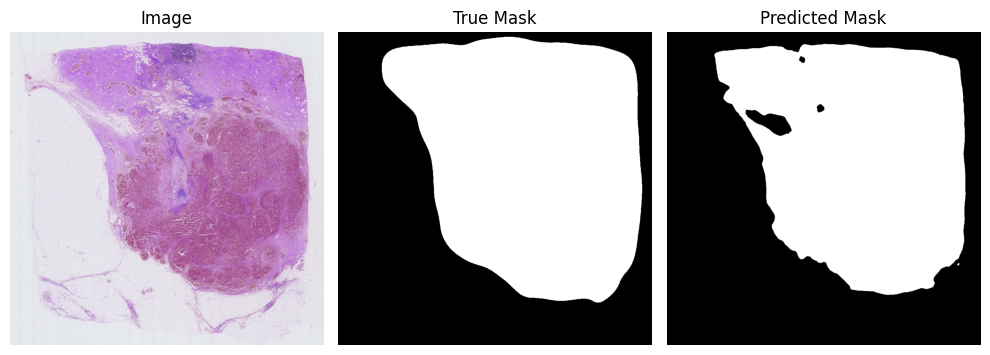

1/1 [==============================] - 0s 32ms/step


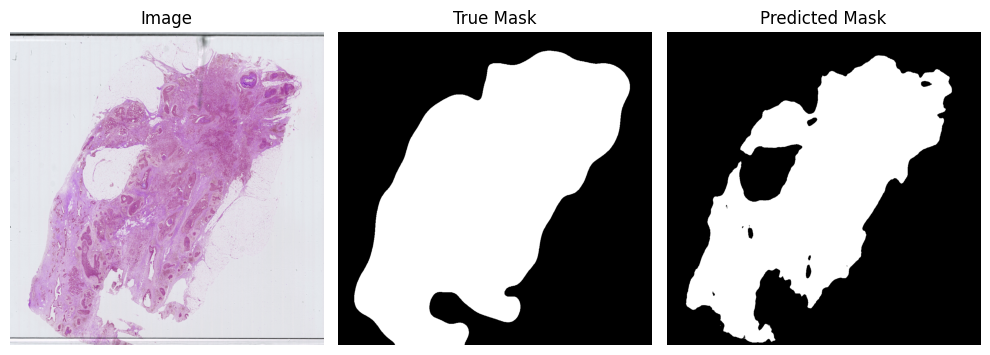

1/1 [==============================] - 0s 31ms/step


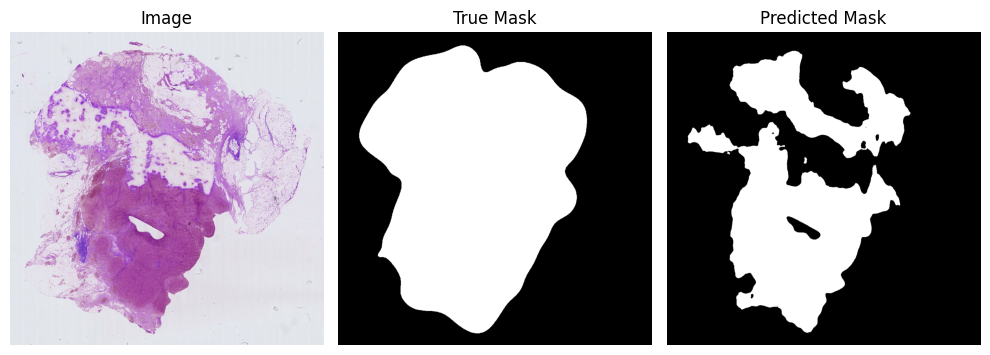

1/1 [==============================] - 0s 28ms/step


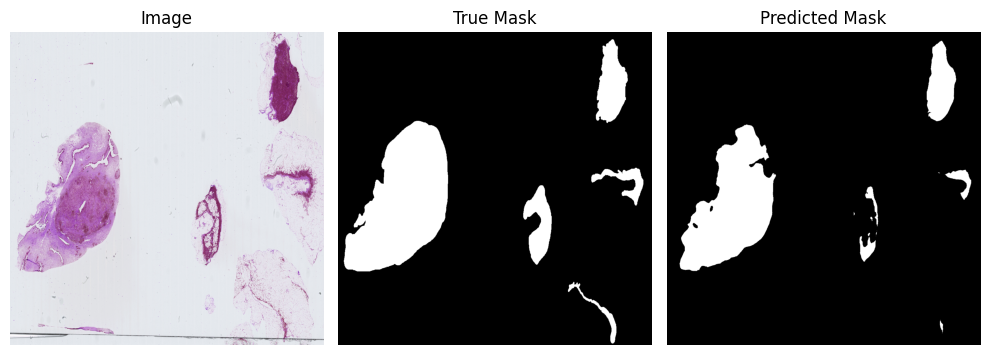

1/1 [==============================] - 0s 28ms/step


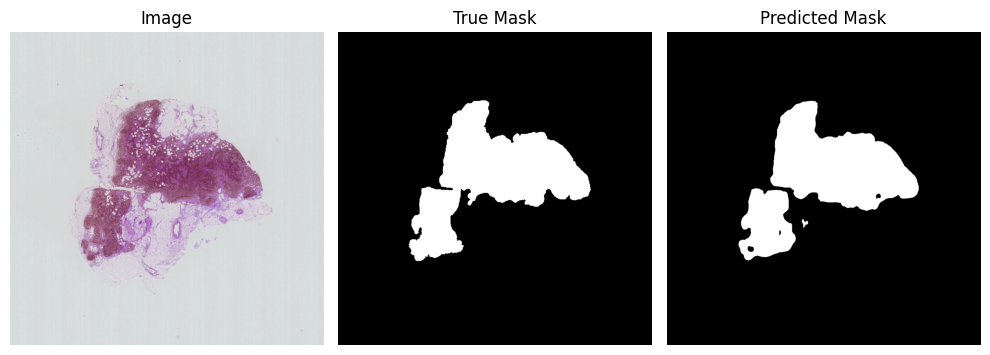

1/1 [==============================] - 0s 36ms/step


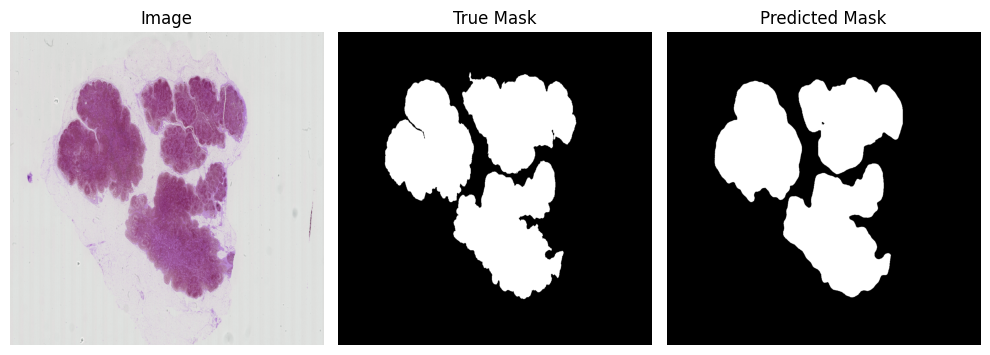

1/1 [==============================] - 0s 27ms/step


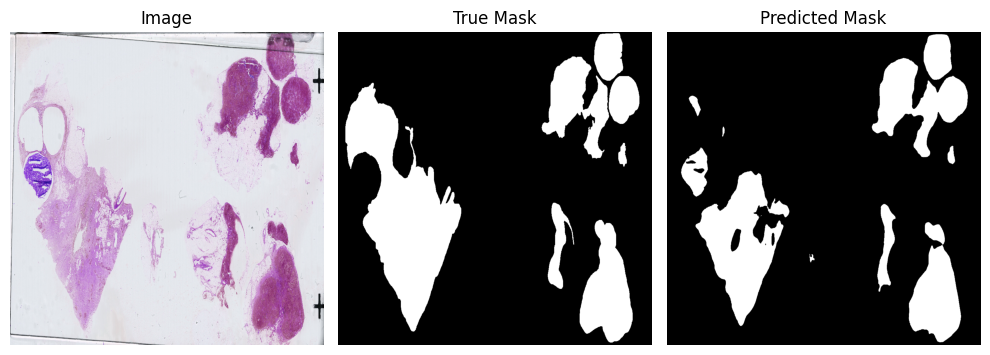

1/1 [==============================] - 0s 29ms/step


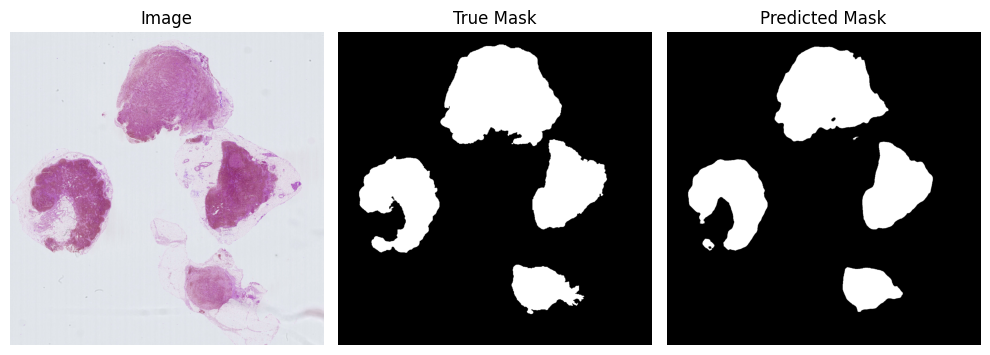

1/1 [==============================] - 0s 33ms/step


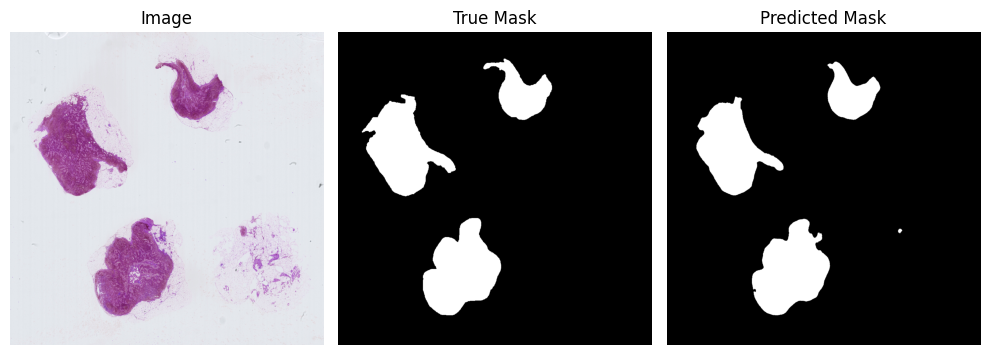

1/1 [==============================] - 0s 29ms/step


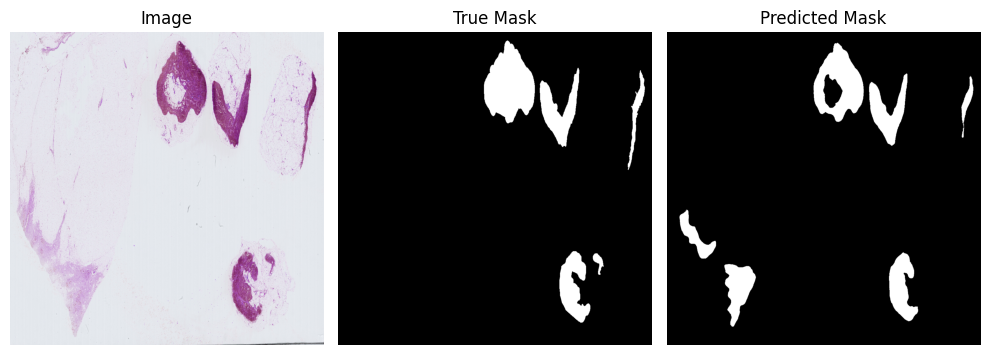

1/1 [==============================] - 0s 27ms/step


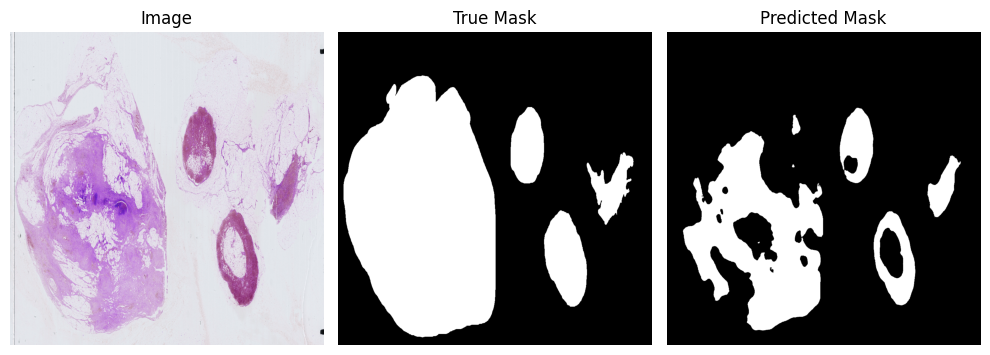

1/1 [==============================] - 0s 33ms/step


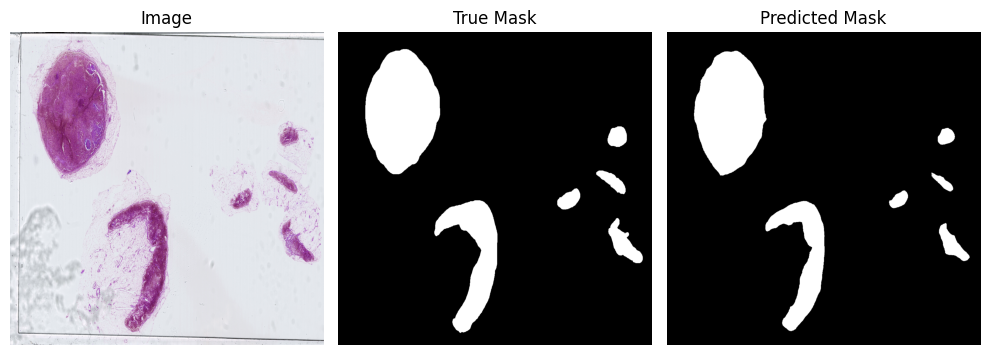

1/1 [==============================] - 0s 26ms/step


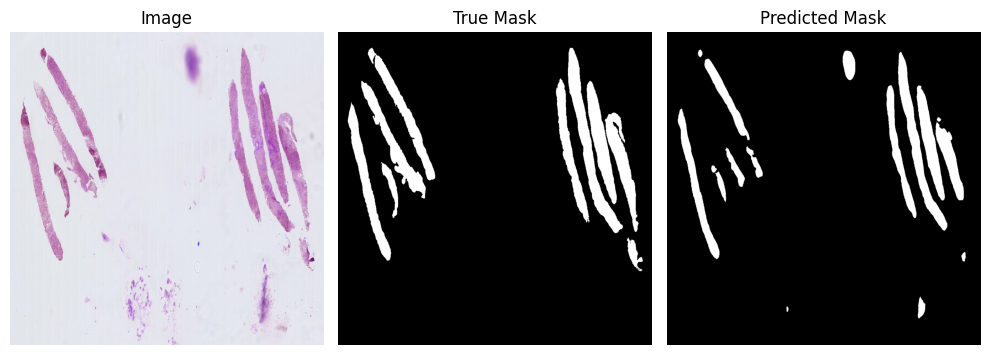

1/1 [==============================] - 0s 33ms/step


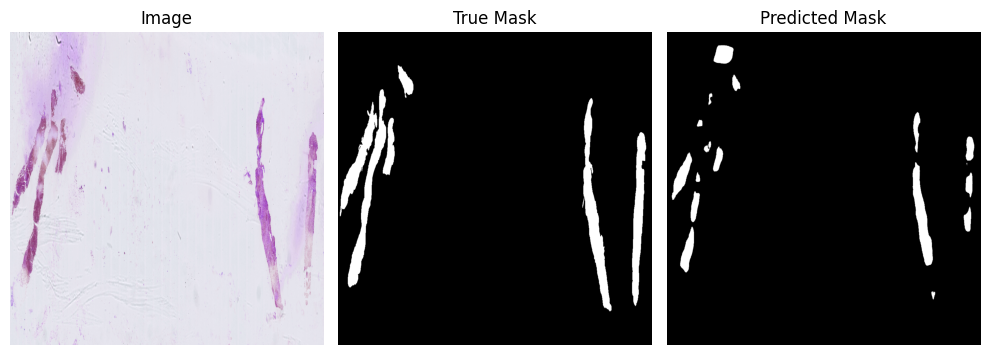

1/1 [==============================] - 0s 28ms/step


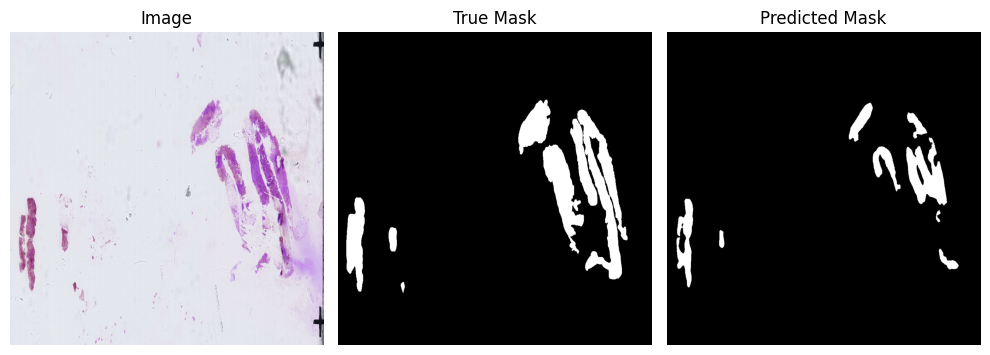

1/1 [==============================] - 0s 27ms/step


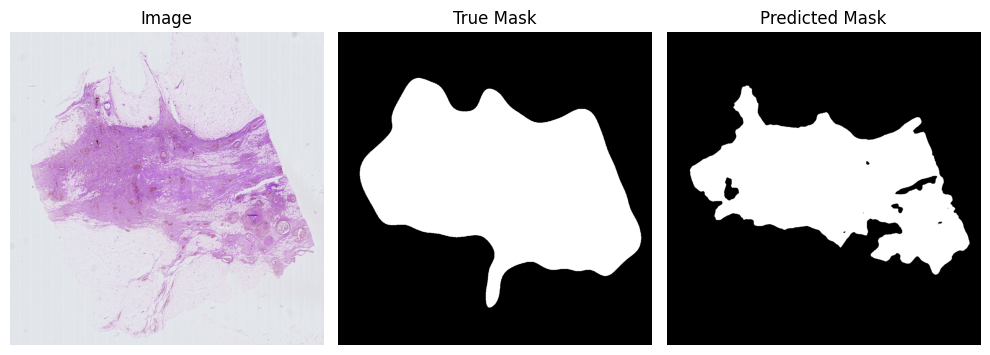

1/1 [==============================] - 0s 26ms/step


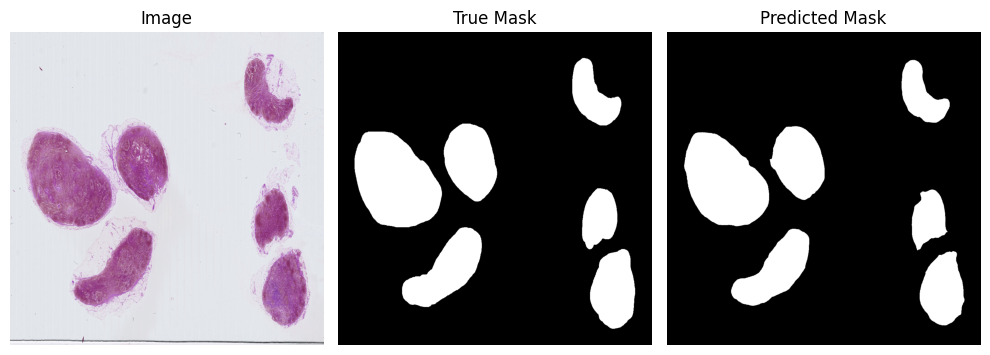

1/1 [==============================] - 0s 28ms/step


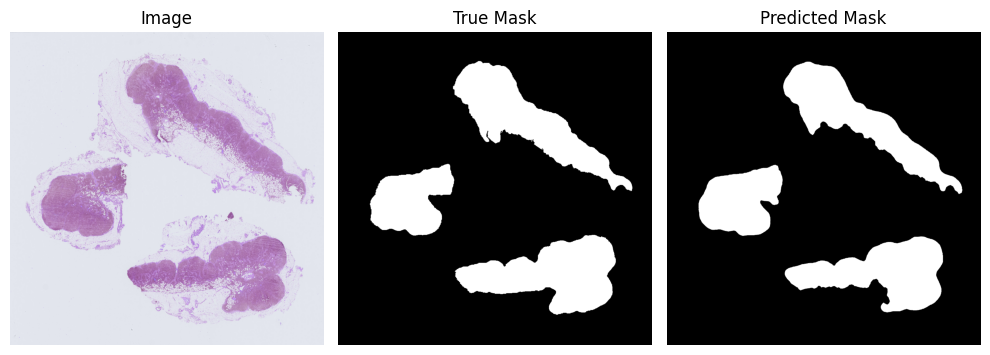

1/1 [==============================] - 0s 34ms/step


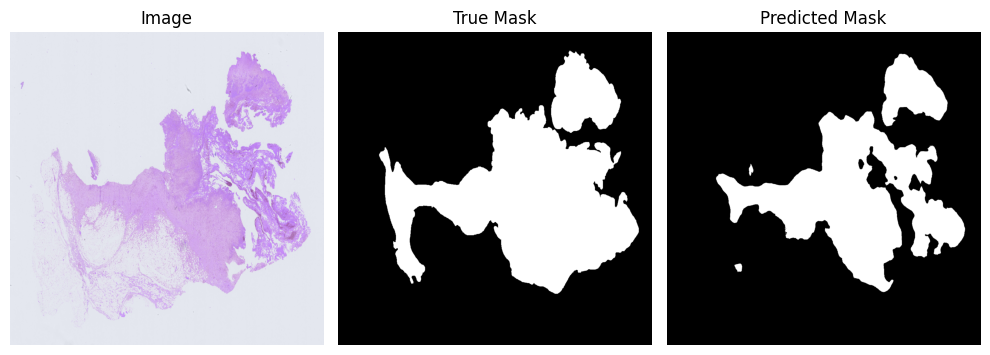

1/1 [==============================] - 0s 26ms/step


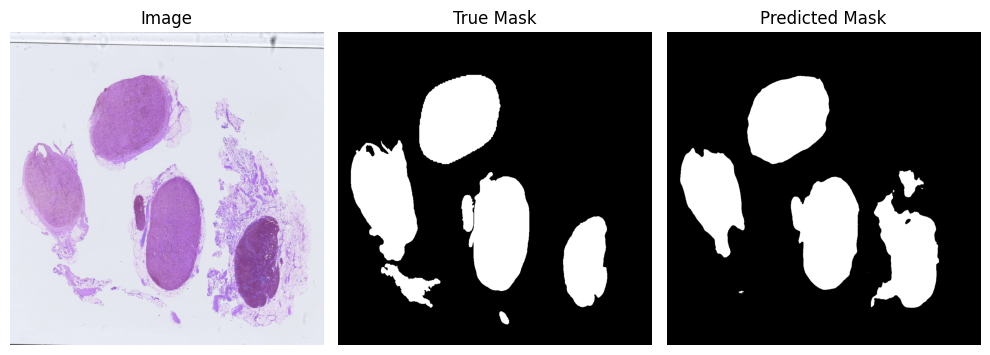

1/1 [==============================] - 0s 27ms/step


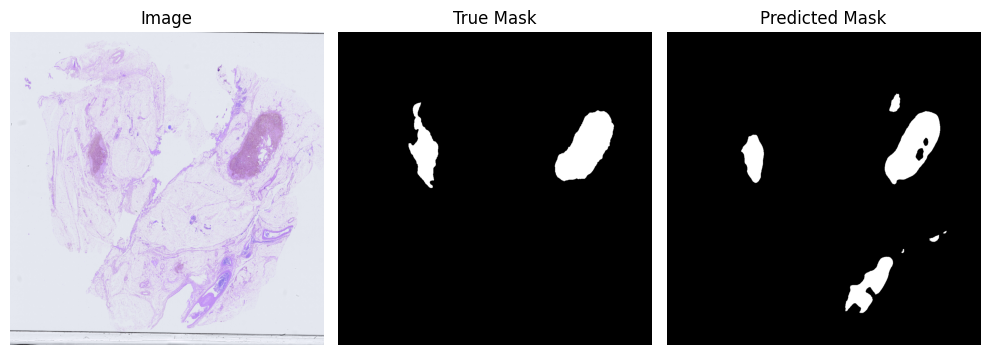

1/1 [==============================] - 0s 26ms/step


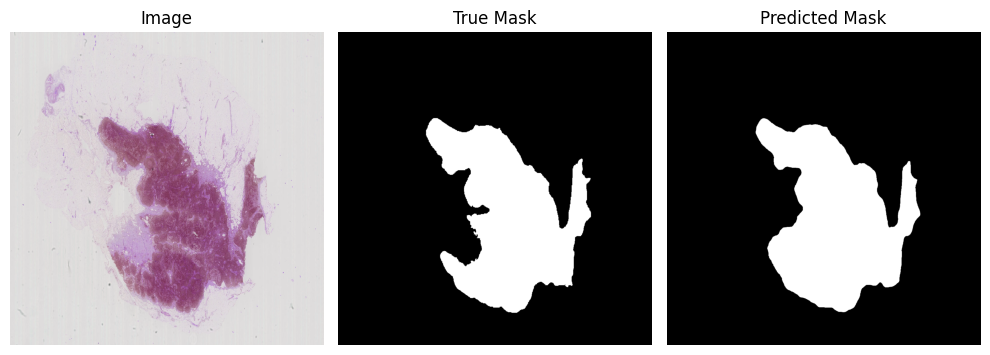

1/1 [==============================] - 0s 29ms/step


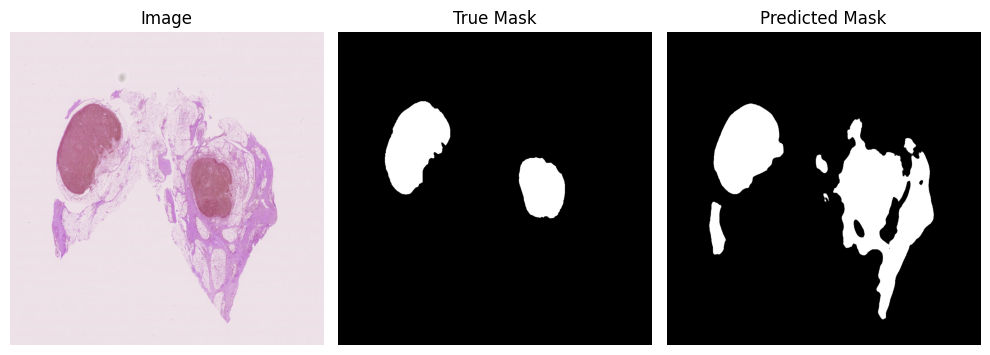

1/1 [==============================] - 0s 26ms/step


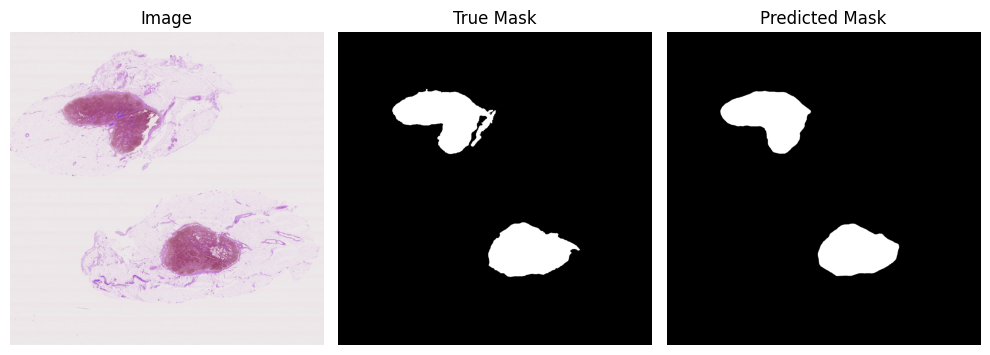

1/1 [==============================] - 0s 26ms/step


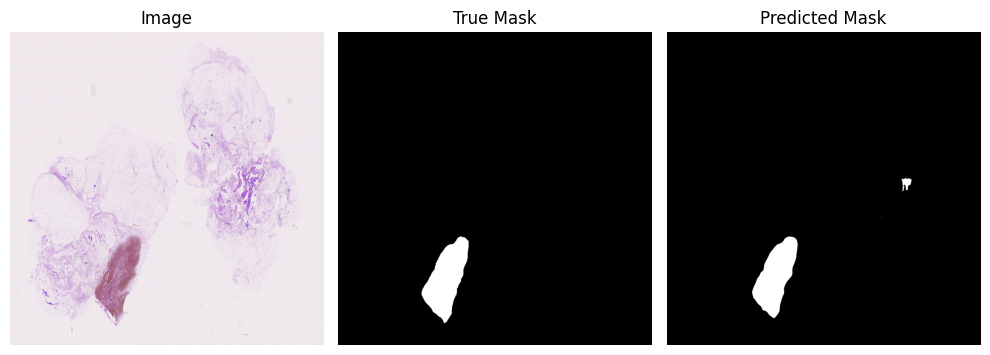

1/1 [==============================] - 0s 32ms/step


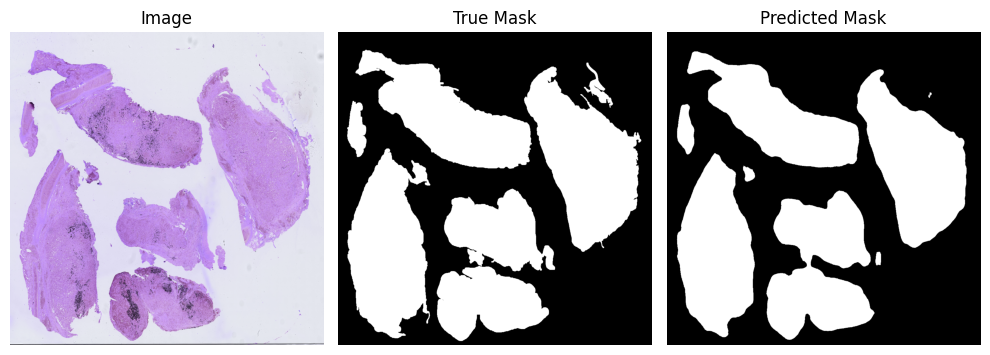

1/1 [==============================] - 0s 26ms/step


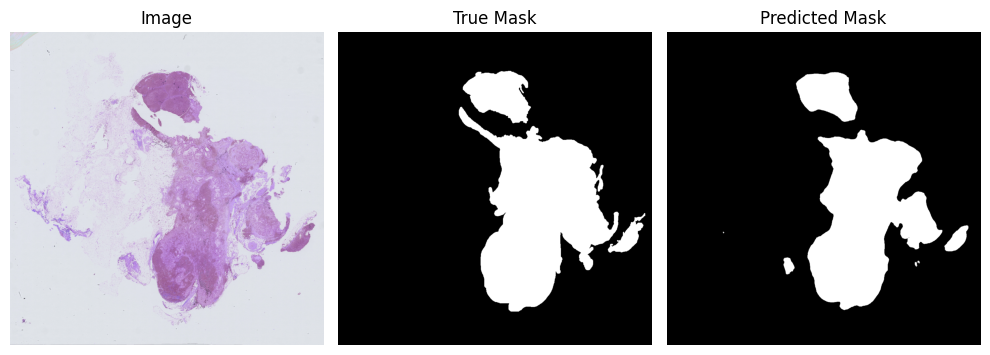

1/1 [==============================] - 0s 34ms/step


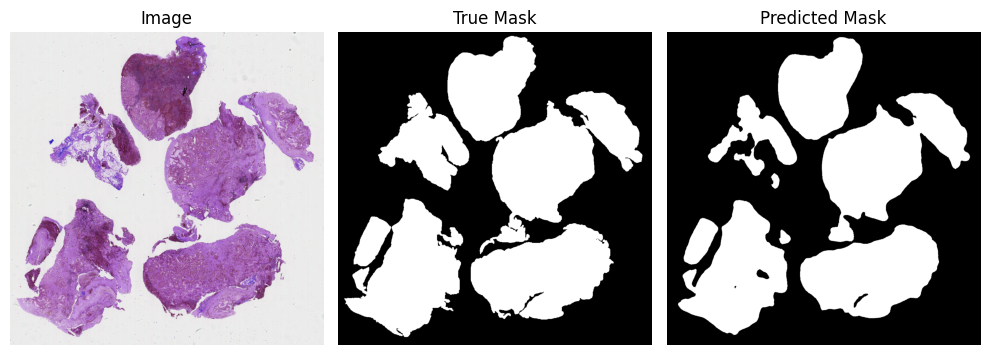

1/1 [==============================] - 0s 29ms/step


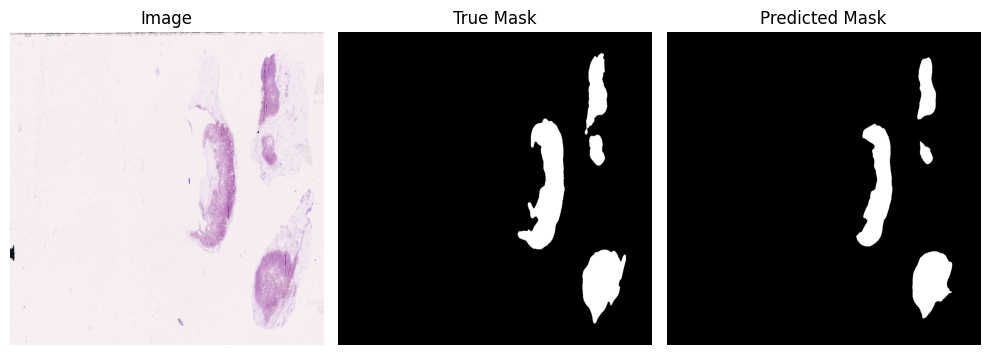

1/1 [==============================] - 0s 29ms/step


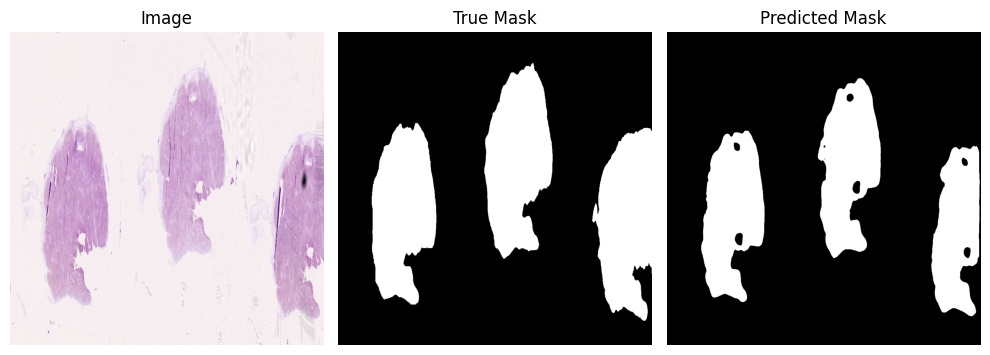

In [ ]:
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1, 0)

    return tf.cast(binary_masks, tf.uint8)

def display_image_with_mask(image, true_mask, predicted_mask):
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 12))

    # Display the image
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[0].axis('off')

    # Display the true mask
    axes[1].imshow(true_mask, cmap='gray')
    axes[1].set_title("True Mask")
    axes[1].axis('off')

    # Display the predicted mask
    axes[2].imshow(predicted_mask, cmap="gray")
    axes[2].set_title("Predicted Mask")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming validation_batches is a generator that yields (image, mask) pairs
validation_images = []  # Store validation images
true_masks = []  # Store true masks
predicted_masks = []  # Store predicted masks

for image, mask in validation_batches:

  # Predict masks with recently trained model:
  probabilities = unet_model.predict(image)

  # Predict the masks using the loaded model:
  #probabilities = loaded_model.predict(image)

  # Get binary predictions
  binary_masks = create_binary_mask(probabilities)

  # Display the images with true and predicted masks
  display_image_with_mask(image[0,:,:,:], mask[0,:,:,0], binary_masks[0,:,:])
